In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker
import scipy.stats as sps
import datetime as dt

import pickle

import arviz as az
import pyjags

from IPython.display import HTML, Latex, Markdown, clear_output

start = dt.datetime.now()

# Italy COVID-19 Rt estimation with MCMC

A simple method is presented to estimate effective reproduction number $R_t$ of COVID-19 in italian regions with a Markov chain Monte Carlo and Poisson likelihood parametrized on daily new cases.

The jupyter notebook backend is available at [GitHub](https://github.com/maxdevblock/COVID-Rt-MCMC).

Method and MCMC diagnostics are available at [PDF](https://maxpierini.it/ncov/Rt-MCMC.pdf).

***

In [2]:
SI_mu = 7.5
SI_sd = 3.4

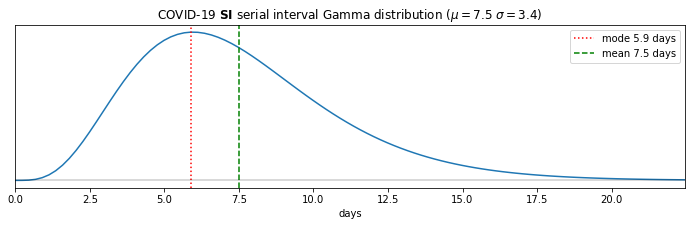

In [3]:
shape = SI_mu**2 / SI_sd**2 
scale = SI_sd**2 / SI_mu
SI_dist = sps.gamma(a=shape, scale=scale)
SI_x = np.linspace(SI_dist.ppf(0), SI_dist.ppf(.999), 100)
SI_y = SI_dist.pdf(SI_x)

omega = SI_x[SI_y.argmax()]
mean = SI_dist.stats(moments="m")

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(SI_x, SI_y)
ax.axvline(omega, c="r", ls=":", label=f"mode {omega:.1f} days")
ax.axvline(mean, c="g", ls="--", label=f"mean {mean:.1f} days")

ax.legend()
ax.axhline(0, c="k", alpha=.2)
ax.set_xlim(0, SI_x.max())
ax.set_yticks([])
ax.set_xlabel("days")
ax.set_title(fr"COVID-19 $\mathbf{{SI}}$ serial interval Gamma distribution ($\mu={SI_mu}$ $\sigma={SI_sd}$)")
plt.show();

In [4]:
adapt = 500
warmup = 1000
sample = 1000

In [5]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
     usecols=['data', 'denominazione_regione', 'nuovi_positivi'],
     parse_dates=['data'],
     index_col=['denominazione_regione', 'data'],
     squeeze=True).sort_index()

countries = df.index.get_level_values("denominazione_regione").unique().sort_values()
days = df.index.get_level_values("data").unique()

In [6]:
it = pd.read_csv(
    "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",
     usecols=['data', 'nuovi_positivi'],
     parse_dates=['data'],
     index_col=['data'],
     squeeze=True).sort_index()

In [7]:
Y = np.ndarray(shape=(countries.size, days.size))

yit = it.rolling(7,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=2).round().values
yit[yit<0] = 0

for r, region in enumerate(countries):

    y = df.loc[region]
    lom = df.loc[region].rolling(7,
                win_type='gaussian',
                min_periods=1,
                center=True).mean(std=2).round().values
    lom[lom<0] = 0
    
    Y[r] = lom
    
model_data = {
    "y": Y,
    "k": Y,
    "C": countries.size,
    "T": days.size
}

In [8]:
modelString = f"""
model {{
    # Overarching Rt standard deviation
    tau_R ~ dgamma( 1000 , 100 )
    sigma_R <- 1 / sqrt( tau_R )

    # Serial interval distribution
    SI_mu <- {SI_mu}
    SI_sd <- {SI_sd}
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    for ( r in 1:C ) {{
        # First Rt prior
        R[r,1] <- 0
        for ( t in 2:T ) {{
            # Rt prior for k>0
            Rpr[r,t] ~ dnorm( R[r,t-1] , tau_R )  T(0,)
            # Rt prior for k=0
            Rnu[r,t] ~ dnorm( 0 , tau_R )  T(0,)

            # Define Rt prior
            R[r,t] <- ifelse( k[r,t-1]==0 , Rnu[r,t] , Rpr[r,t] )
            # Avoid k=0 (undefined Rt)
            K[r,t] <- ifelse( k[r,t-1]==0, 1 , k[r,t-1] )

            # Poisson likelihood
            lambda[r,t] <- K[r,t] * exp( gamma * ( R[r,t] - 1 ) )
            y[r,t] ~ dpois( lambda[r,t] )
        }}
    }}
}}
"""

In [9]:
jags_model = pyjags.Model(
    code=modelString, 
    data=model_data,
    chains=4, 
    adapt=adapt,
    progress_bar=False
)

jags_posteriors = jags_model.sample(warmup + sample, vars=["R", "sigma_R", "tau_R"])

# Abruzzo

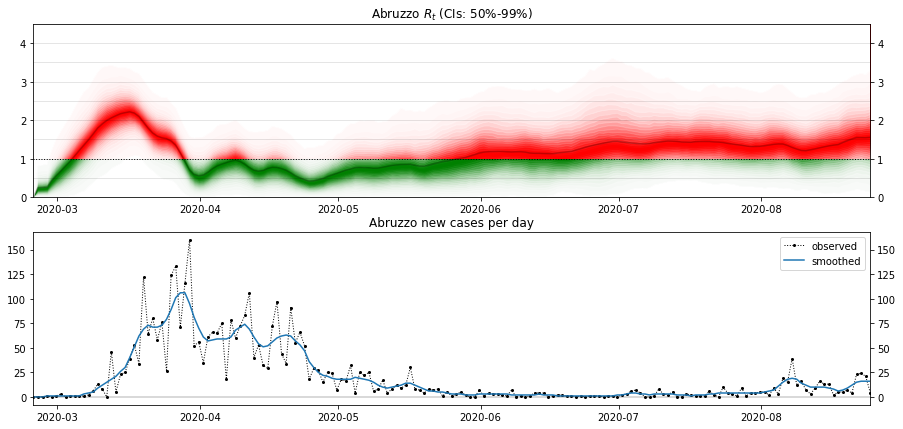

***

# Basilicata

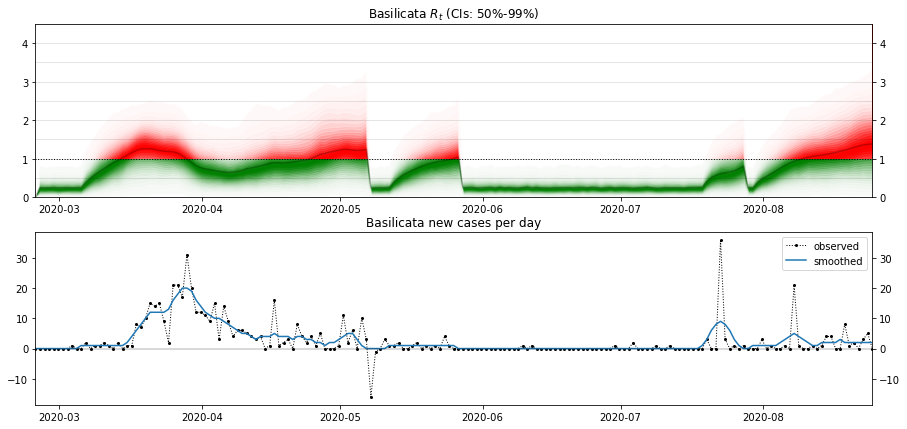

***

# Calabria

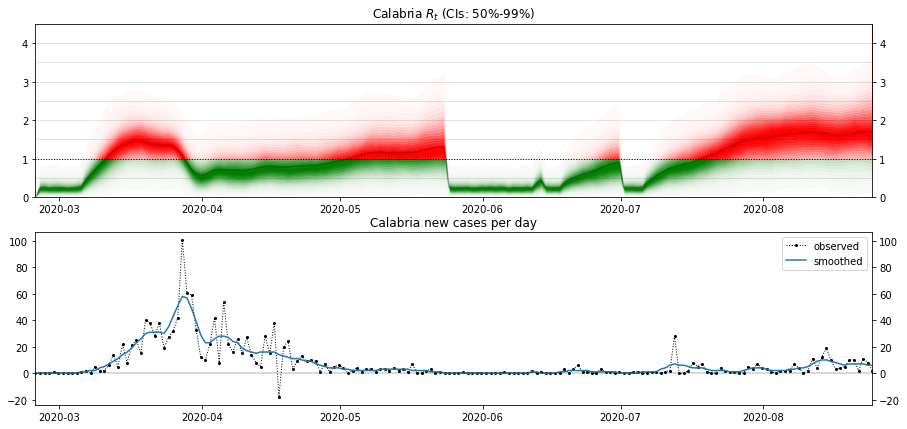

***

# Campania

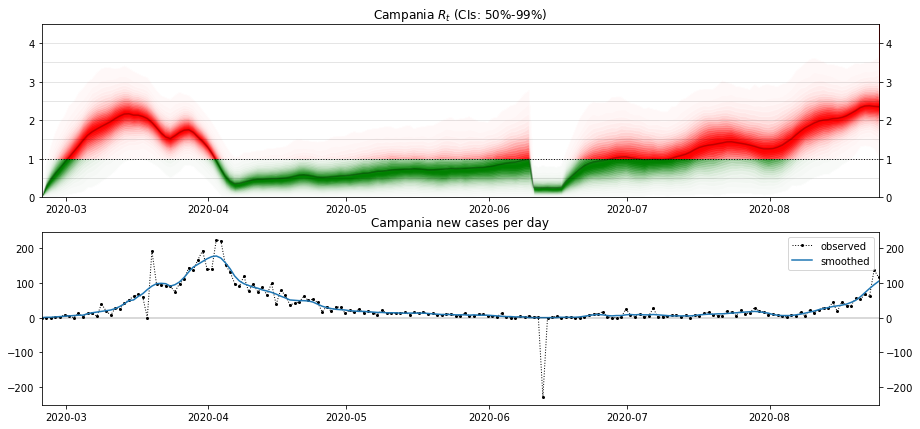

***

# Emilia-Romagna

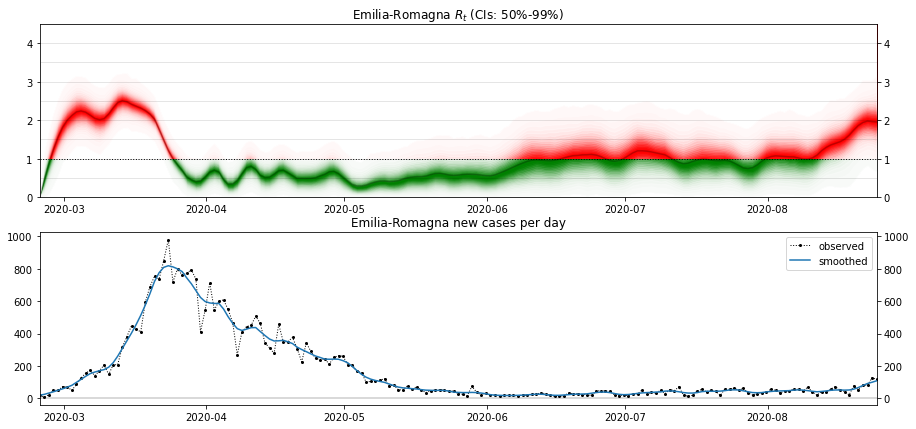

***

# Friuli Venezia Giulia

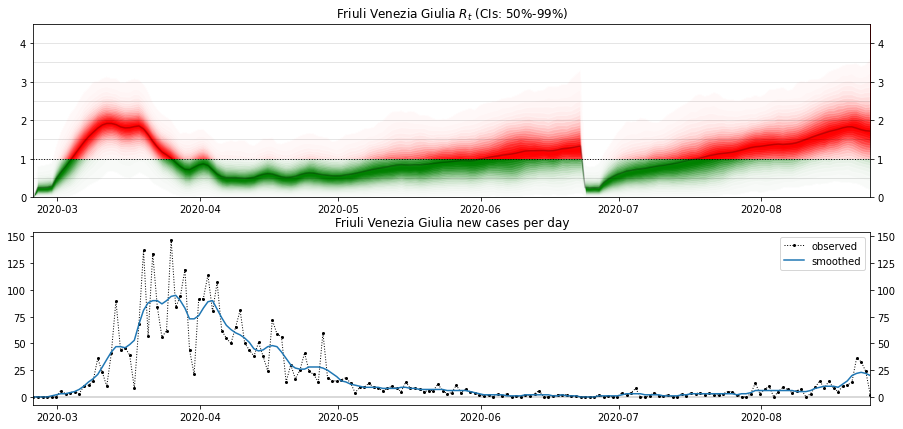

***

# Lazio

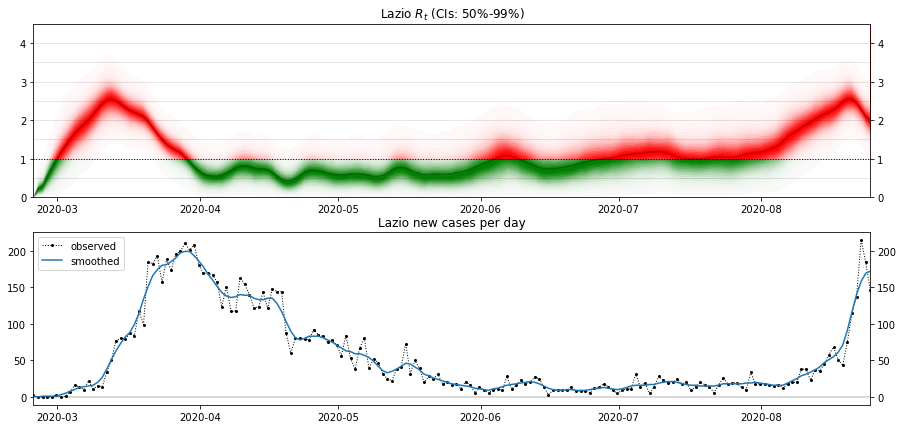

***

# Liguria

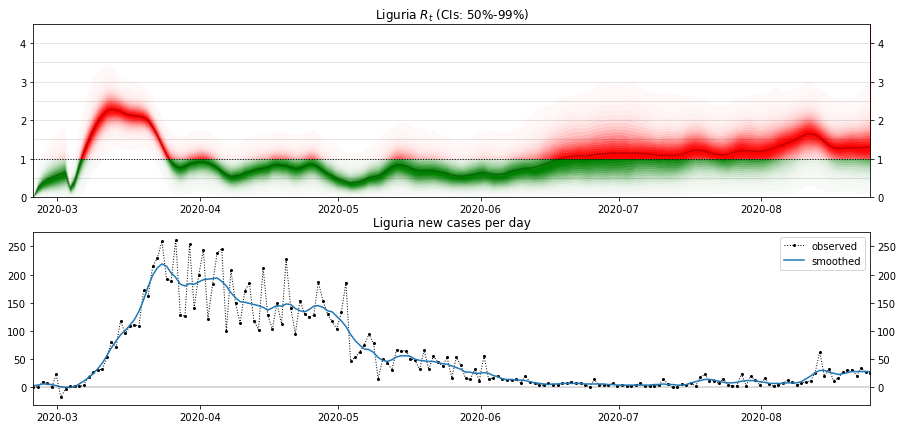

***

# Lombardia

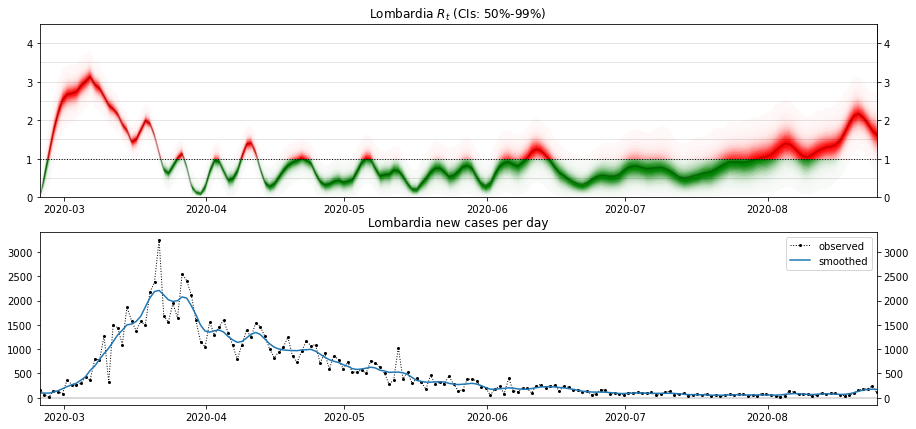

***

# Marche

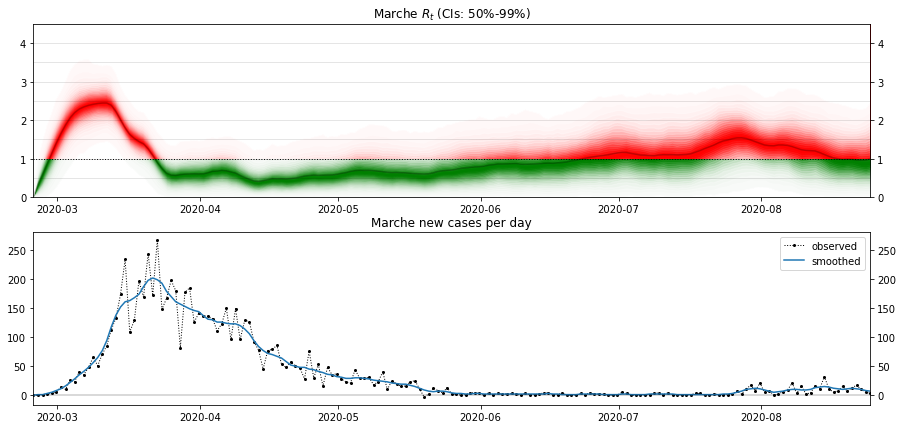

***

# Molise

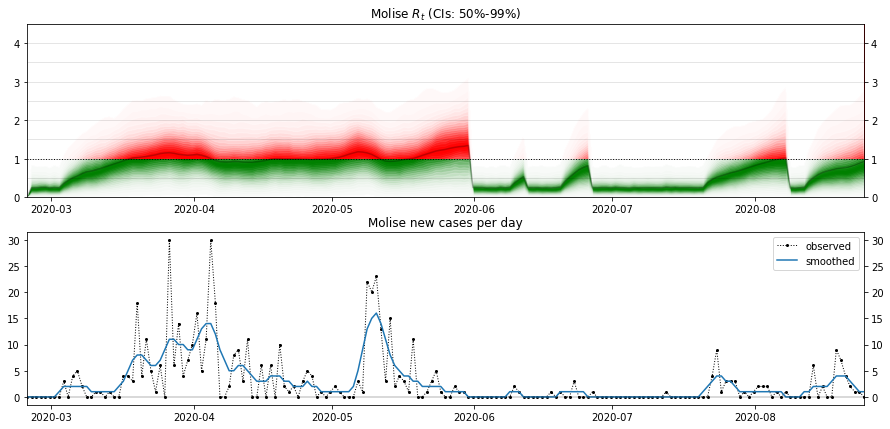

***

# P.A. Bolzano

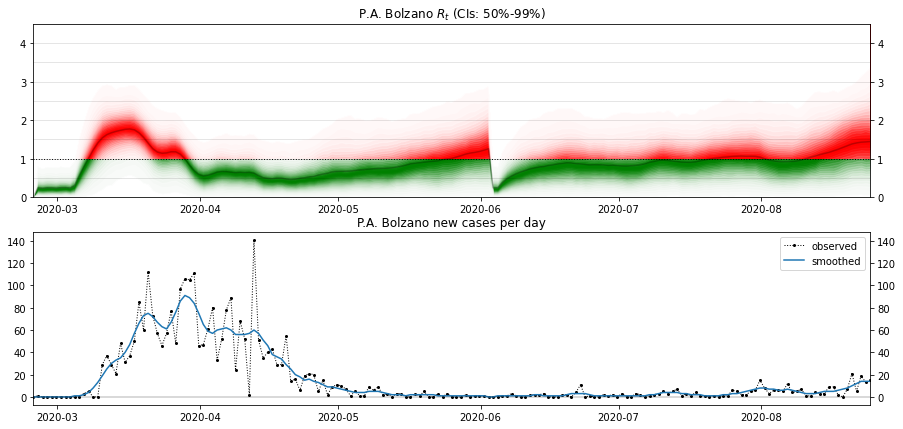

***

# P.A. Trento

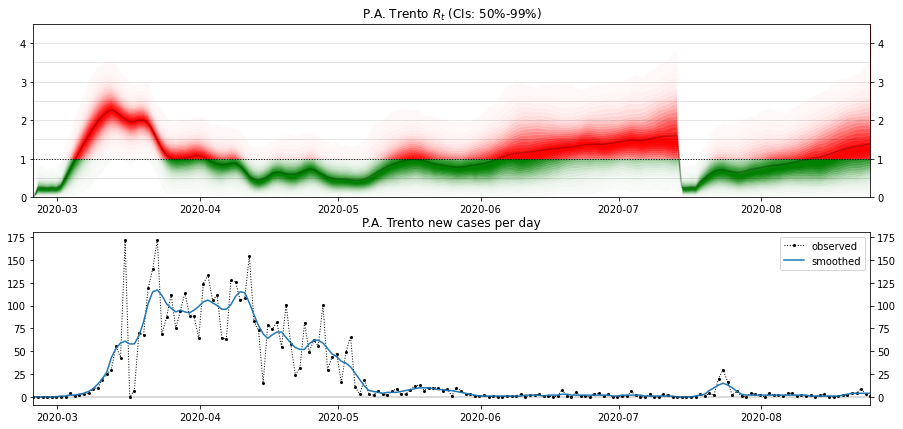

***

# Piemonte

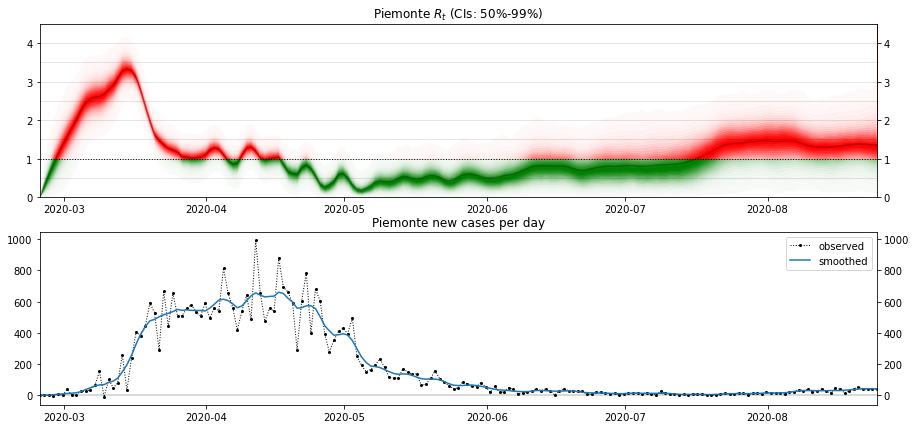

***

# Puglia

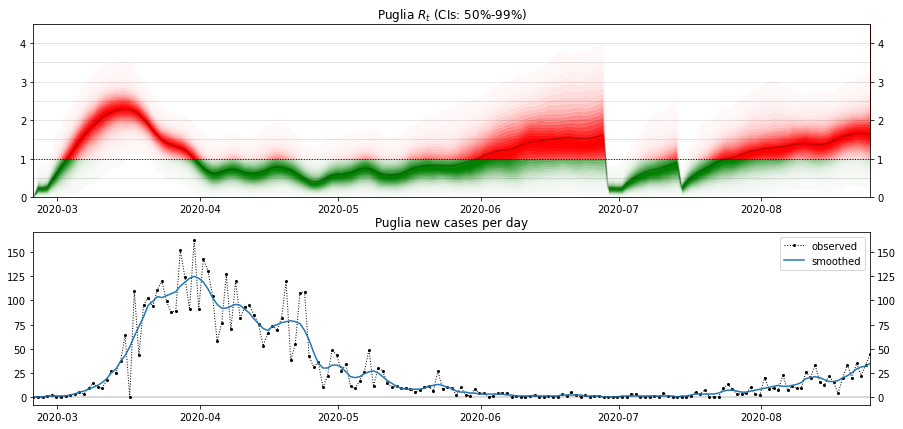

***

# Sardegna

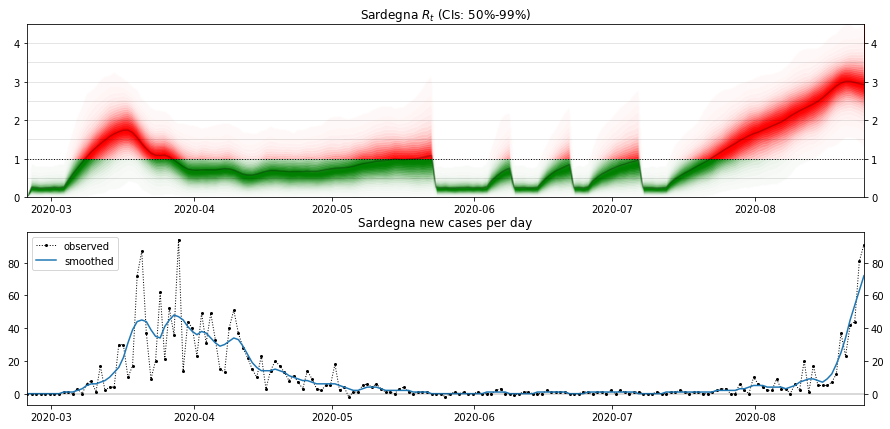

***

# Sicilia

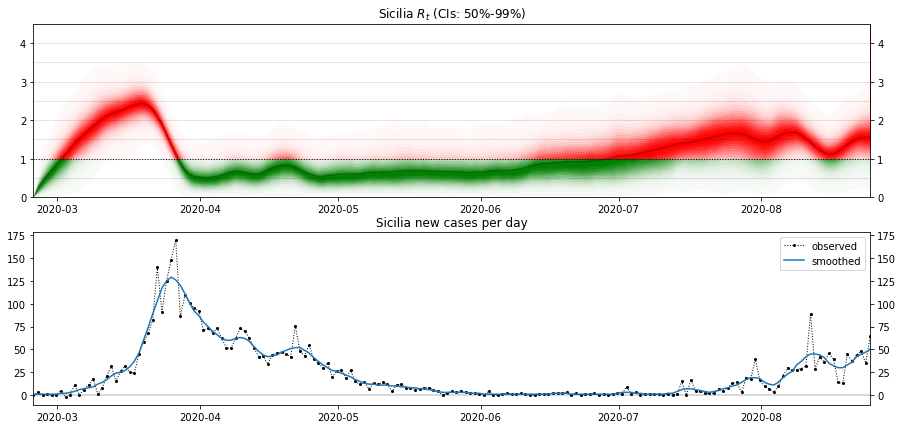

***

# Toscana

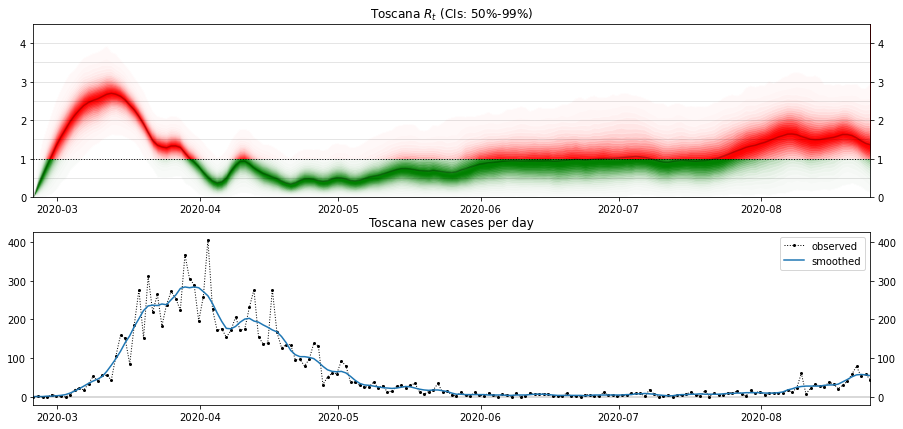

***

# Umbria

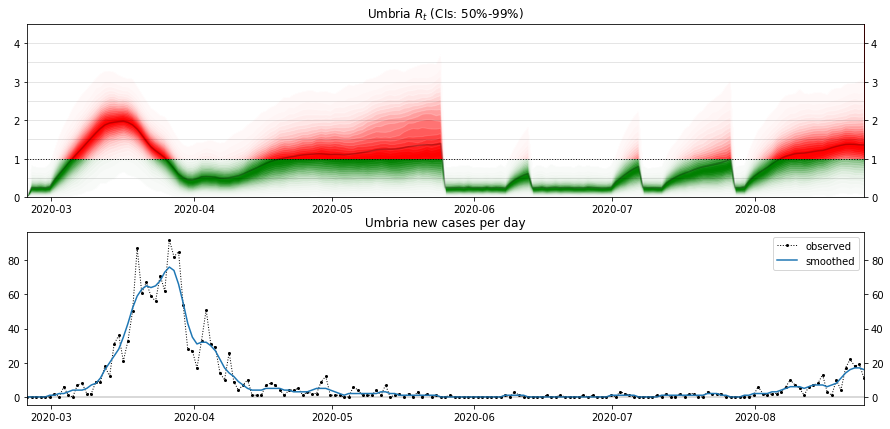

***

# Valle d'Aosta

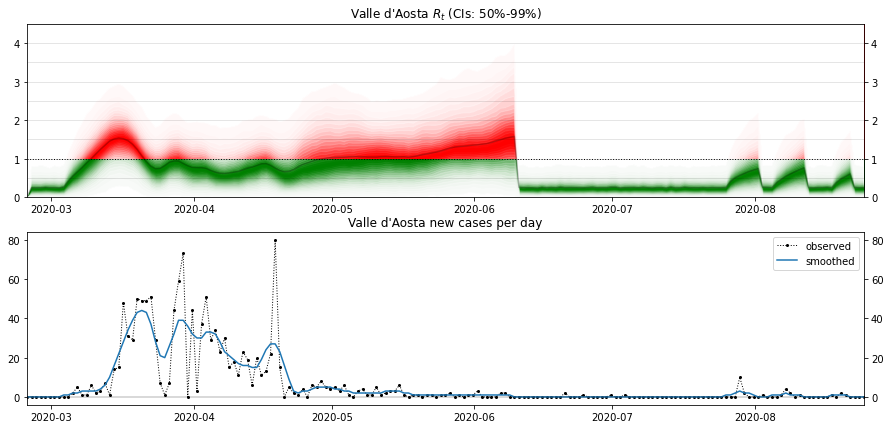

***

# Veneto

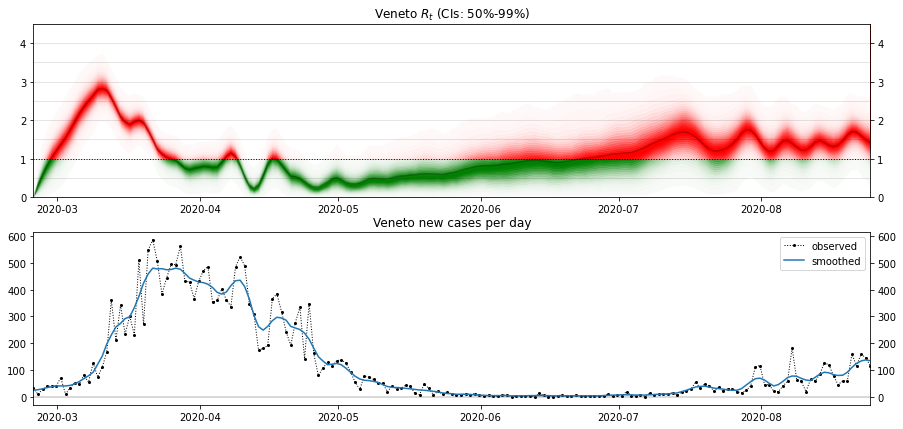

***

In [10]:
percs = np.linspace(50, 99, 20)

ymax = np.array([])
uppers = np.ndarray(shape=(countries.size, len(percs), days.size))
lowers = np.ndarray(shape=(countries.size, len(percs), days.size))
means = np.ndarray(shape=(countries.size, days.size))
for r, region in enumerate(countries):
    
    pyjags_data_test = az.from_pyjags({"R": jags_posteriors["R"][r]}, warmup_iterations=warmup, save_warmup=False)
    summary = az.summary(pyjags_data_test, var_names="^R", filter_vars="regex", kind="stats")
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(pyjags_data_test.posterior.R, p, axis=1)
        upper = np.mean(upper, axis=0)
        lower = np.percentile(pyjags_data_test.posterior.R, 100-p, axis=1)
        lower = np.mean(lower, axis=0)
        ymax = np.append(ymax, upper[2:].max())
        uppers[r,i] = upper
        lowers[r,i] = lower
        means[r] = summary["mean"]
ymax = ymax.max()

for r, region in enumerate(countries):
        
    display(Markdown(f"# {region}"))
    
    fig, ax = plt.subplots(2, 1, figsize=(15,7))

    ax[1].plot(days, df.loc[region].values, 'ok:', lw=1, ms=2, label="observed")
    ax[1].plot(days, Y[r], label="smoothed")
    ax[1].axhline(0, c="k", alpha=.2)
    ax[1].set_xlim(days[0], days[-1])
    ax[1].yaxis.set_ticks_position('both')
    ax[1].tick_params(labelright=True)
    ax[1].legend()
    ax[1].set_title(f"{region} new cases per day")

    steps = .4/(len(percs)-1)
    for i, (upper, lower) in enumerate(zip(uppers[r], lowers[r])):
        alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
        ax[0].fill_between(days, np.zeros(lower.size), lower, color="w", alpha=alpha)
        ax[0].fill_between(days, upper, np.ones(lower.size)*12, color="w", alpha=alpha)

    ax[0].plot(days, means[r], c="k", alpha=.25)

    ax[0].hlines(np.arange(0, 12, .5), days[0], days[-1], color="k", lw=1, alpha=.1)
    ax[0].axhline(1, c="k", ls=":", lw=1)

    ax[0].fill_between(days, 1, 12, color="red", zorder=0)
    ax[0].fill_between(days, 0, 1, color="green", zorder=0)

    ax[0].set_xlim(days[0], days[-1])

    ax[0].set_title(fr"{region} $R_t$ (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")
    
    ax[0].set_ylim(0, ymax)
    ax[0].yaxis.set_ticks_position('both')
    ax[0].tick_params(labelright=True)
    
    plt.show()
    plt.close(fig="all")
    
    display(Markdown("***"))

# Latest Rt

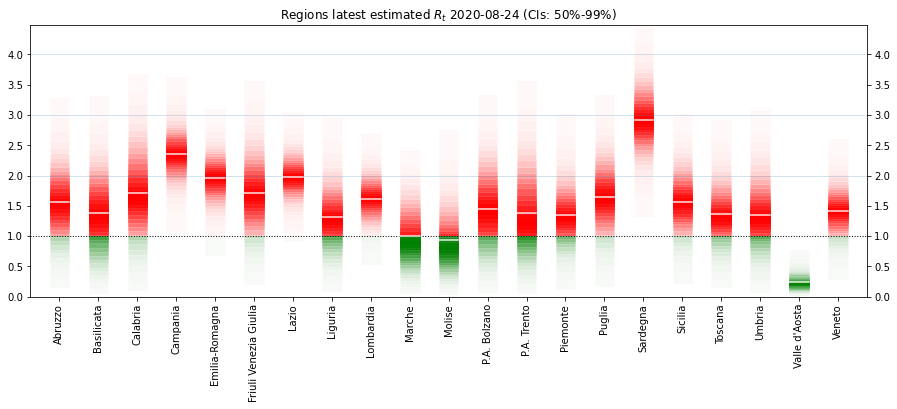

In [11]:
fig, ax = plt.subplots(figsize=(15,5))

for r, region in enumerate(countries):
    steps = .4/(len(percs)-1)
    for i, (upper, lower) in enumerate(zip(uppers[r,:,-1], lowers[r,:,-1])):
        alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
        ax.fill_between([r*2,r*2+1], 1, 12, color="red", zorder=0)
        ax.fill_between([r*2,r*2+1], 0, 1, color="green", zorder=0)
        ax.fill_between(np.linspace(r*2,r*2+1,10), np.zeros(10), lower, color="w", alpha=alpha)
        ax.fill_between(np.linspace(r*2,r*2+1,10), upper, np.ones(10)*12, color="w", alpha=alpha)
    ax.plot(np.linspace(r*2,r*2+1,10), np.ones(10)*means[r][-1], color="w", alpha=.9, zorder=100)

ax.axhline(1, c="k", ls=":", lw=1)
ax.hlines(np.arange(2, 12, 1), -1, countries.size*2+1, lw=1, alpha=.2)
ax.set_ylim(0, ymax)
ax.set_xlim(-1, countries.size*2)
ax.set_xticks(np.arange(.5, countries.size*2+.5, 2))
ax.set_xticklabels(countries.values, rotation=90)
ax.yaxis.set_ticks_position('both')
ax.tick_params(labelright=True)
ax.set_title(f"Regions latest estimated $R_t$ {days[-1].date()} (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")
plt.show();

# Italy

In [12]:
pyjags_data_tau = az.from_pyjags(
    {"tau_R": jags_posteriors["tau_R"]}, 
    warmup_iterations=warmup, save_warmup=False)

summary_tau = az.summary(pyjags_data_tau)

modelStringItaly = f"""
model {{
    # Estimated Rt precision tau
    tau_R <- {summary_tau['mean'][0]}
    
    # Serial interval distribution
    SI_mu <- {SI_mu}
    SI_sd <- {SI_sd}
    SI_sh <- SI_mu^2 / SI_sd^2
    SI_ra <- SI_mu / SI_sd^2
    SI ~ dgamma( SI_sh , SI_ra )
    gamma <- 1 / SI
    
    # First Rt prior
    R[1] <- 0
    for ( t in 2:T ) {{
        # Rt prior for k>0
        Rpr[t] ~ dnorm( R[t-1] , tau_R )  T(0,)
        # Rt prior for k=0
        Rnu[t] ~ dnorm( 0 , tau_R )  T(0,)

        # Define Rt prior
        R[t] <- ifelse( k[t-1]==0 , Rnu[t] , Rpr[t] )
        # Avoid k=0 (undefined Rt)
        K[t] <- ifelse( k[t-1]==0, 1 , k[t-1] )

        # Poisson likelihood
        lambda[t] <- K[t] * exp( gamma * ( R[t] - 1 ) )
        y[t] ~ dpois( lambda[t] )
    }}
}}
"""

In [13]:
model_data_italy = {
    "y": yit,
    "k": yit,
    "T": days.size
}

In [14]:
jags_model_italy = pyjags.Model(
    code=modelStringItaly, 
    data=model_data_italy,
    chains=4, 
    adapt=adapt,
    progress_bar=False
)

jags_posteriors_italy = jags_model_italy.sample(warmup + sample, vars=["R"])

adapting: iterations 2000 of 2000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 7364 of 8000, elapsed 0:00:10, remaining 0:00:01
sampling: iterations 8000 of 8000, elapsed 0:00:11, remaining 0:00:00


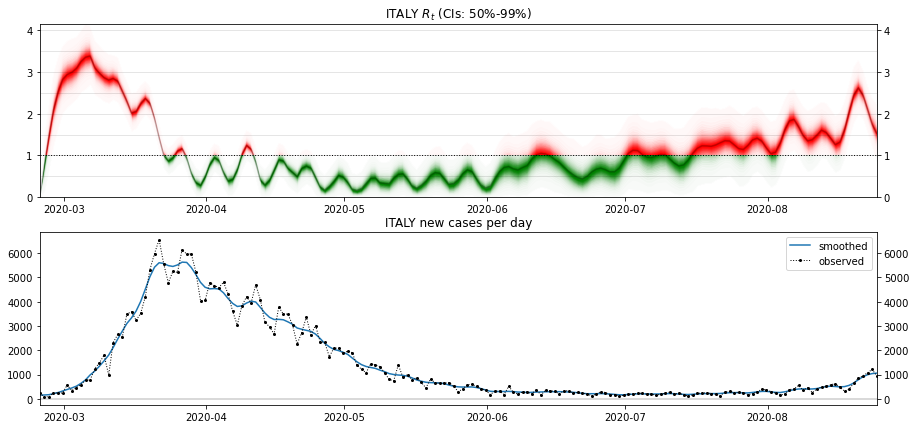

In [15]:
percs = np.linspace(50, 99, 20)

ymax = np.array([])
uppers = np.ndarray(shape=(len(percs), days.size))
lowers = np.ndarray(shape=(len(percs), days.size))

pyjags_data_italy = az.from_pyjags(jags_posteriors_italy, warmup_iterations=warmup, save_warmup=False)
summary = az.summary(pyjags_data_italy, var_names="^R", filter_vars="regex", kind="stats")
for i, p in enumerate(percs[::-1]):
    upper = np.percentile(pyjags_data_italy.posterior.R, p, axis=1)
    upper = np.mean(upper, axis=0)
    lower = np.percentile(pyjags_data_italy.posterior.R, 100-p, axis=1)
    lower = np.mean(lower, axis=0)
    ymax = np.append(ymax, upper.max())
    uppers[i] = upper
    lowers[i] = lower
ymax = ymax.max()

        
fig, ax = plt.subplots(2, 1, figsize=(15,7))

ax[1].plot(days, yit, label="smoothed")
ax[1].plot(days, it, 'ok:', lw=1, ms=2, label="observed")
ax[1].axhline(0, c="k", alpha=.2)
ax[1].set_xlim(days[0], days[-1])
ax[1].yaxis.set_ticks_position('both')
ax[1].tick_params(labelright=True)
ax[1].legend()
ax[1].set_title(f"ITALY new cases per day")

steps = .4/(len(percs)-1)
for i, (upper, lower) in enumerate(zip(uppers, lowers)):
    alpha = 1-(i*steps)-(.6*np.ceil(i/len(percs)))
    ax[0].fill_between(days, np.zeros(lower.size), lower, color="w", alpha=alpha)
    ax[0].fill_between(days, upper, np.ones(lower.size)*12, color="w", alpha=alpha)

ax[0].plot(days, summary["mean"], c="k", alpha=.25)

ax[0].hlines(np.arange(0, 12, .5), days[0], days[-1], color="k", lw=1, alpha=.1)
ax[0].axhline(1, c="k", ls=":", lw=1)

ax[0].fill_between(days, 1, 12, color="red", zorder=0) #, alpha=.2)
ax[0].fill_between(days, 0, 1, color="green", zorder=0) #, alpha=.2)

ax[0].set_xlim(days[0], days[-1])

ax[0].set_title(fr"ITALY $R_t$ (CIs: {percs[0]:.0f}%-{percs[-1]:.0f}%)")

ax[0].set_ylim(0, ymax)
ax[0].yaxis.set_ticks_position('both')
ax[0].tick_params(labelright=True)

plt.show()
plt.close(fig="all")

***

In [16]:
end = dt.datetime.now()
print(f"Completed in {end - start}")

Completed in 0:12:36.077525
